In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
data=pd.read_csv(f'../03.dataset/NTPC_model_features_clean.csv')
#data = data.iloc[:,0:30]
#data.info()

In [3]:
data_class = pd.get_dummies(data['鄉鎮市區'])
#data = data.loc[data['交易標的'] == 0]
data_class.columns = ['鄉鎮市區_' + str(x) for x in data_class.columns]
data = pd.concat([data, data_class], axis = 1)
print(data.shape[1])

131


In [4]:
data.insert(data.shape[1], 'y', data['單價元平方公尺'])
data.drop(['單價元平方公尺'],axis=1,inplace=True)
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.drop(['Unnamed: 0.1'],axis=1,inplace=True)
data.drop(['Unnamed: 0.2'],axis=1,inplace=True)
data.drop(['鄉鎮市區'],axis=1,inplace=True)
#data = data.loc[data['備註'].isnull()]
#data.drop(['備註'],axis=1,inplace=True)
data.drop(['geometry'],axis=1,inplace=True)

In [5]:
data = data.loc[:, data.std() > 0]
data = data.dropna()

In [26]:
print(data.columns[0:25])

Index(['交易標的', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '有無管理組織', '主建物面積', '附屬建物面積',
       '陽台面積', '電梯', '屋齡', '交易年份', 'floor', 'total_floor', '車位類別_一樓平面',
       '車位類別_其他', '車位類別_升降平面', '車位類別_升降機械', '車位類別_坡道平面', '車位類別_坡道機械',
       '車位類別_塔式車位', '建物型態-公寓', '建物型態-華廈', '建物型態-住宅大樓', '建物型態-套房',
       'NEAR_HOSTIPAL_250'],
      dtype='object')


In [7]:
test_data = data.loc[data['交易年份'] >= 111]
train_data =  data.loc[data['交易年份'] < 111]
#train_data = train_data.loc[data['交易年份'] > 107]

In [8]:
feature_count = data.shape[1]
print(feature_count)

126


In [9]:
#from sklearn.preprocessing import StandardScaler

In [10]:
#scaler = StandardScaler()
#scaler.fit(train_data)

In [11]:
#data_norm = scaler.transform(train_data)
#pd.DataFrame(data_norm).describe()

In [12]:
#X = data_norm[:,0:115]
#y = data_norm[:,115]
#X = data_norm[:,0:feature_count-1]
#y = data_norm[:,feature_count-1]

In [13]:
mean = train_data.mean()
std = train_data.std()
train_data = (train_data-mean)/std

In [14]:
X_train = np.array(train_data.drop('y', axis='columns'))
y_train = np.array(train_data['y'])

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=4)

In [17]:
from sklearn.neural_network import MLPRegressor

In [18]:
model_mlp = MLPRegressor(random_state=14,max_iter = 400,activation='relu', hidden_layer_sizes=(int(data.shape[1]*1/2),int(data.shape[1]*1/4)))
model_mlp.fit(X_train, y_train)
mlp_score=model_mlp.score(X_train,y_train)

In [19]:
test_data = (test_data - mean) / std
#test_data = test_data.loc[test_data['y'] >= 3]
X_test = np.array(test_data.drop('y', axis='columns'))
y_test = np.array(test_data['y'])

In [20]:
print('score:',mlp_score)
result = model_mlp.predict(X_test)

score: 0.9170696972935333


In [21]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': result})
df1 = df.head(10)
df1

,Actual,Predicted
0,0.603101,1.004878
1,2.337506,2.650258
2,-0.000451,0.404980
3,-1.799081,-1.803601
4,-1.353926,-1.101365
5,2.903241,1.965383
6,-0.517908,-0.135699
7,0.552110,0.966310
8,0.015082,0.151754
9,-0.215026,-0.282119


C:\Users\tazz4\anaconda3\envs\ox\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

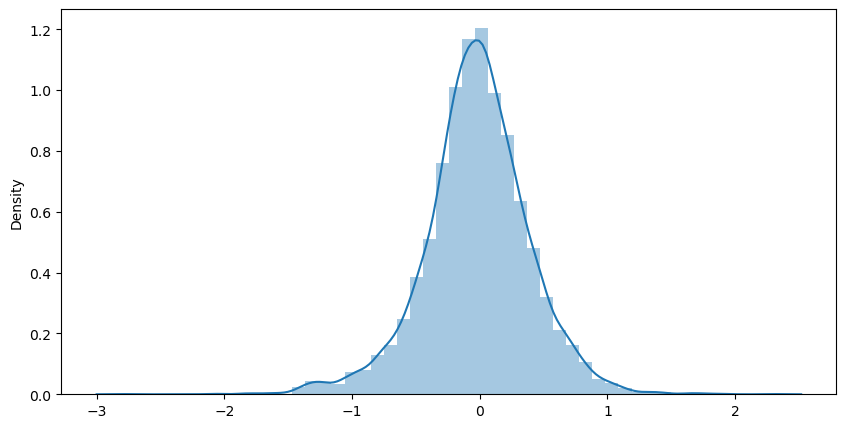

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10,5))
residuals = (y_test- result)
sns.distplot(residuals)

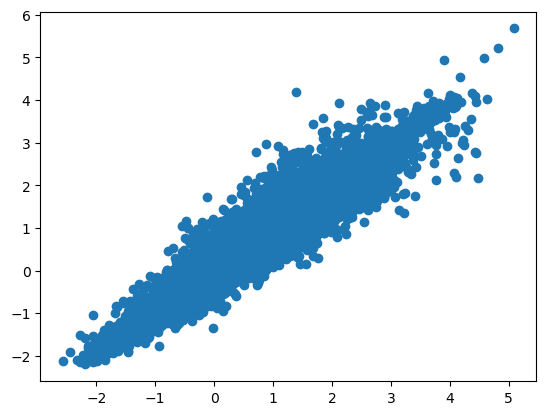

In [23]:
plt.scatter(y_test, result)
plt.plot([0,1],[0,1])

In [24]:
data1 = pd.DataFrame({'origin':y_test * std['y'] + mean['y'],'predict':result* std['y'] + mean['y'],
                     'residual':(y_test * std['y'] + mean['y']) - (result* std['y'] + mean['y'])})
percentage_error = np.mean(np.abs(data1['origin'] - data1['predict'])) / np.mean(data1['origin']) * 100
data1['residual_abs'] = data1['residual'].abs()
data1['y10'] = data1['origin'] / 10 - data1['residual_abs']
data1['y20'] = data1['origin'] / 5 - data1['residual_abs']
data1['y30'] = data1['origin'] / 3.333 - data1['residual_abs']
data1.loc[data1['y10'] >= 0, 'y10'] = 1
data1.loc[data1['y10'] < 0 , 'y10'] = 0
data1.loc[data1['y20'] >= 0, 'y20'] = 1
data1.loc[data1['y20'] < 0 , 'y20'] = 0
data1.loc[data1['y30'] >= 0, 'y30'] = 1
data1.loc[data1['y30'] < 0 , 'y30'] = 0
print(data1)
print(f'預測房價落在實際房價+-10%內的機率為:{round(data1["y10"].mean(),4)*100}%')
print(f'預測房價落在實際房價+-20%內的機率為:{round(data1["y20"].mean(),4)*100}%')
print(f'預測房價落在實際房價+-30%內的機率為:{round(data1["y30"].mean(),4)*100}%')
print("Model Percentage Error: {:.2f}%".format(percentage_error))

        origin        predict      residual  residual_abs  y10  y20  y30
0     111940.0  125571.308025 -13631.308025  13631.308025  0.0  1.0  1.0
1     170784.0  181394.912756 -10610.912756  10610.912756  1.0  1.0  1.0
2      91463.0  105218.271693 -13755.271693  13755.271693  0.0  1.0  1.0
3      30440.0   30286.660559    153.339441    153.339441  1.0  1.0  1.0
4      45543.0   54111.753164  -8568.753164   8568.753164  0.0  1.0  1.0
...        ...            ...           ...           ...  ...  ...  ...
8022  115590.0  101443.438711  14146.561289  14146.561289  0.0  1.0  1.0
8023  132443.0  124624.341025   7818.658975   7818.658975  1.0  1.0  1.0
8024  121065.0  100481.862784  20583.137216  20583.137216  0.0  1.0  1.0
8025  179111.0  186817.020672  -7706.020672   7706.020672  1.0  1.0  1.0
8026  158356.0  151822.223763   6533.776237   6533.776237  1.0  1.0  1.0

[8027 rows x 7 columns]
預測房價落在實際房價+-10%內的機率為:62.4%
預測房價落在實際房價+-20%內的機率為:89.03999999999999%
預測房價落在實際房價+-30%內的機率為:96.71%
Mode

In [25]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print(f"mean_absolute_error: {mean_absolute_error(y_test, result)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, result)}")
print(f"mean_squared_error: {mean_squared_error(y_test, result)}")
print(f"explained_variance_score: {explained_variance_score(y_test, result)}")
print(f"r2_score: {r2_score(y_test, result)}")
#print(f"r2_adj_score: {1 - (1 - r2_score(y_test, result)) * (feature_count - 1) / (df.shape[0] - feature_count - 1)}")

mean_absolute_error: 0.3078701902951038
mean_absolute_percentage_error: 2.0789426955724264
mean_squared_error: 0.1703195130144199
explained_variance_score: 0.8696790696954773
r2_score: 0.8692087567104883
